# Большое практическое задание 2

# Применение линейных моделей для определения токсичности комментария

## курс "Машинное обучение 1", программа OzonMasters, 2021

## Студент: Арешин Станислав Олегович

## Теоретическая часть (1 балл)
**Выведите формулу градиента функции потерь (по параметру $w$) для задачи бинарной логистической регрессии.**

$$L(a(x), y) = \log(1 + \exp(-y\langle w, x\rangle)), \quad y \in \{-1, 1\}$$

Запишите вывод градиента ниже.

*Решение*

Запишем полную формулу с регуляризацией:

$$L(a(x), y) = \frac{1}{N}\log(1 + \exp(-y\langle w, x\rangle)) + l_2\|w\|_2^2 $$

Далее по шагам:

1) Вычислим $\frac{\partial{l_2\|w\|_2^2}}{\partial{w}}$

$$\frac{\partial{l_2\|w\|_2^2}}{\partial{w}} = l_2\frac{\partial{\|w\|_2^2}}{\partial{w}} = l_2\frac{\partial{\langle w, w\rangle}}{\partial{w}} = $$
$$= l_2(\langle w, dw\rangle + \langle dw, w\rangle) = l_2\langle 2w, dw\rangle$$

Таким образом, 

$$\frac{\partial{l_2\|w\|_2^2}}{\partial{w}} = 2l_2w $$

2) Вычислим $\frac{\partial{\log(1 + \exp(-y\langle w, x\rangle))}}{\partial{w}}$

$$\frac{\partial{\log(1 + \exp(-y\langle w, x\rangle))}}{\partial{w}} = \frac{\frac{\partial{(-y\langle w,x\rangle)}}{\partial{w}} \cdot \exp(-y\langle w, x\rangle)}{1 + \exp(-y\langle w, x\rangle)} $$

    2.1
    
$$\frac{\partial{(-y\langle w,x\rangle)}}{\partial{w}} = -y(\langle dw, x\rangle + 0) = -yx$$

Таким образом, 

$$\frac{\partial{\log(1 + \exp(-y\langle w, x\rangle))}}{\partial{w}} = -yx \frac{\exp(-y\langle w, x\rangle)}{1 + \exp(-y\langle w, x\rangle)} = -yx \sigma(-y\langle w, x\rangle)$$ 

3) Итого состыкуем 1) и 2), не забывая про $\frac{1}{N}$, получаем:

$$\frac{1}{N}(-yx \sigma(-y\langle w, x\rangle)) + 2l_2w$$
 



## Реализация алгоритмов (9 баллов)
Прототипы функций должны строго соответствовать прототипам, описанным в спецификации и проходить все
тесты. Задание, не проходящее все тесты, приравнивается к невыполненному. 


При написании необходимо пользоваться стандартными средствами языка Python, библиотеками `numpy, scipy и matplotlib`. Библиотекой `scikit-learn` для реализаций пользоваться запрещается, но разрешается использовать её в процессе экспериментов. Все
подробности реализации алгоритмов подробно описаны в [спецификации](https://drive.google.com/file/d/1cby1SXsS0TkeFd-3AkE2j1JhKYU9Er1N/view) к заданию.


Ожидается, что реализациия всех классов и функций будет максимально эффективной. 

## Предобработка данных (2 балла)
Импортируйте все, что вам потребуется для экспериментов:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from modules.linear_model import LinearModel
from modules.losses import BinaryLogisticLoss, MultinomialLoss
from modules.utils import get_numeric_grad, compute_balanced_accuracy

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

### 1. Загрузка даннных
Эксперименты этого задания необходимо проводить на датасете, содержащим комментарии из раздела обсуждений английской Википедии, который был преобразован для решения задачи бинарной классификации: является ли данный комментарий токсичным или нет. Подробнее об исходных данных [здесь](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Требуемый для выполнения данного задания датасет можно найти по следующей [ссылке](https://drive.google.com/file/d/1FLTAFR29Koi4YDkLUdVQWNabnBQCTFbn/view). 


Данные в датасете записаны в формате `csv`. Для базовой части экспериментов используйте в качестве целевой переменной столбец `is_toxic`. Обратите внимание на метки классов в датасете, замените их на те, которые ожидает увидеть на вход ваша реализация `LinearModel`.

In [3]:
df_train = pd.read_csv('train.csv').drop(['toxic_level', 'insult', 'obscene',
                                    'obscene_and_insult', 'no_obscene_no_insult'], axis = 1)
df_train.head()

comment_text  is_toxic
0  Explanation\nWhy the edits made under my usern...         0
1  D'aww! He matches this background colour I'm s...         0
2  Hey man, I'm really not trying to edit war. It...         0
3  "\nMore\nI can't make any real suggestions on ...         0
4  You, sir, are my hero. Any chance you remember...         0

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  159571 non-null  object
 1   is_toxic      159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
df_test = pd.read_csv('test.csv').drop(['toxic_level', 'insult', 'obscene',
                                    'obscene_and_insult', 'no_obscene_no_insult'], axis = 1)
df_test.head()

comment_text  is_toxic
0  Thank you for understanding. I think very high...         0
1                   :Dear god this site is horrible.         0
2  "::: Somebody will invariably try to add Relig...         0
3  " \n\n It says it right there that it IS a typ...         0
4  " \n\n == Before adding a new product to the l...         0

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63978 entries, 0 to 63977
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  63978 non-null  object
 1   is_toxic      63978 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 999.8+ KB


In [7]:
df_train['is_toxic'] = df_train['is_toxic'].apply(lambda x: -1 if x == 0 else 1)
df_test['is_toxic'] = df_test['is_toxic'].apply(lambda x: -1 if x == 0 else 1)
pd.unique(df_train['is_toxic']), pd.unique(df_train['is_toxic'])

(array([-1,  1], dtype=int64), array([-1,  1], dtype=int64))

### 2. Предобработка текста
Произведите предварительную обработку текста. Приведите все тексты к нижнему регистру. Замените в тексте все символы, не являющиеся буквами и цифрами, на пробелы. Примените алгоритм лемматизации (например, `WordNetLemmatizer` из библотеки `nltk`) к коллекции. Удалите из текста стоп-слова (например, используя список стоп-слов из `nltk`).

**Замечание.** Полезные функции: `str.lower, str.split, str.isalnum, re.sub, re.split`.

По примеру с семинара я реализовал класс предобработки текста. Потом можно модифицировать для других языков.

In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from functools import lru_cache

class Text_preproc():
    def __init__(self, language):
        if language == 'english':
            self.bad_reg = re.compile('[^a-z\s\d]')
            self.stopwords = set(stopwords.words('english'))
            eng_lemmatizer = WordNetLemmatizer()
            @lru_cache(maxsize=10 ** 6)
            def lru_eng_lemmatizer(word):
                return eng_lemmatizer.lemmatize(word)
            self.lemmatizer = lru_eng_lemmatizer
        else:
             raise NotImplementedError('Not supported language')
            
    def __call__(self, text):
        text = text.lower()
        text = re.sub(self.bad_reg, ' ', text)
        text = re.sub('\n|\t', ' ', text)
        text = re.sub(' +', ' ', text)
        lemmas = [self.lemmatizer(word) for word in text.split()]
        lemmas = [word for word in lemmas if word not in self.stopwords]
        
        return ' '.join(lemmas)    

In [9]:
preprocessor = Text_preproc('english')

In [10]:
df_train['clear_comment_text'] = df_train['comment_text'].apply(preprocessor)
df_train.head()

comment_text  is_toxic  \
0  Explanation\nWhy the edits made under my usern...        -1   
1  D'aww! He matches this background colour I'm s...        -1   
2  Hey man, I'm really not trying to edit war. It...        -1   
3  "\nMore\nI can't make any real suggestions on ...        -1   
4  You, sir, are my hero. Any chance you remember...        -1   

                                  clear_comment_text  
0  explanation edits made username hardcore metal...  
1  aww match background colour seemingly stuck th...  
2  hey man really trying edit war guy constantly ...  
3  make real suggestion improvement wondered sect...  
4                      sir hero chance remember page

In [11]:
df_train.drop(['comment_text'], axis = 1, inplace=True)
df_train.head()

is_toxic                                 clear_comment_text
0        -1  explanation edits made username hardcore metal...
1        -1  aww match background colour seemingly stuck th...
2        -1  hey man really trying edit war guy constantly ...
3        -1  make real suggestion improvement wondered sect...
4        -1                      sir hero chance remember page

In [12]:
df_test['clear_comment_text'] = df_test['comment_text'].apply(preprocessor)
df_test.head()

comment_text  is_toxic  \
0  Thank you for understanding. I think very high...        -1   
1                   :Dear god this site is horrible.        -1   
2  "::: Somebody will invariably try to add Relig...        -1   
3  " \n\n It says it right there that it IS a typ...        -1   
4  " \n\n == Before adding a new product to the l...        -1   

                                  clear_comment_text  
0  thank understanding think highly would revert ...  
1                             dear god site horrible  
2  somebody invariably try add religion really me...  
3  say right type type institution needed case th...  
4  adding new product list make sure relevant add...

In [13]:
df_test.drop(['comment_text'], axis = 1, inplace=True)
df_test.head()

is_toxic                                 clear_comment_text
0        -1  thank understanding think highly would revert ...
1        -1                             dear god site horrible
2        -1  somebody invariably try add religion really me...
3        -1  say right type type institution needed case th...
4        -1  adding new product list make sure relevant add...

### 3. Train/val
Разделите данные на обучение и валидацию. Для валидации выберете $30\%$ случайных объектов из датасета. Рекомендуется использовать функцию `sklearn.model_selection.train_test_split`.

In [14]:
X_train = np.array(df_train['clear_comment_text'])
y_train = np.array(df_train['is_toxic'])
X_train.shape, y_train.shape

((159571,), (159571,))

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train,  y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

print(f'Train shape: {X_train.shape, y_train.shape}')
print(f'Validation shape: {X_val.shape, y_val.shape}')

Train shape: ((111699,), (111699,))
Validation shape: ((47872,), (47872,))


### 4. Tf-idf
Преобразуйте текст в разреженную матрицу `scipy.sparse.csr_matrix`, где значение $x$ в позиции $(i, j)$ сответствует tf-idf характеристке $j$-го слова в $i$-ом документе. Рекомендуется использовать конструктор `sklearn.feature_extraction.text.TfidfVectorizer`. Добавьте в данные единичный столбец на **нулевой** позиции.

**Замечание 1.** У `TfidfVectorizer` есть несколько методов для работы, используйте `fit_transform` и `fit` для обучающей выборки, используйте `transform` для тестовой.


**Замечание 2.** Используйте параметр `min_df`, чтобы уменьшить размерность данных и ускорить проведение экспериментов. Рекомендуется использовать `min_df` не меньше $5$.


**Замечание 3.** Для добавления единичного столбца, можно воспользоваться следующей инструкцией:
```python
from scipy.sparse import hstack, csr_matrix
X = csr_matrix(hstack([csr_matrix(np.ones((X.shape[0], 1))), X]))
```

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

vectorizer = TfidfVectorizer(min_df=5)

X_train = vectorizer.fit_transform(X_train)
X_train = csr_matrix(hstack([csr_matrix(np.ones((X_train.shape[0], 1))), X_train]))

X_val = vectorizer.transform(X_val)
X_val = csr_matrix(hstack([csr_matrix(np.ones((X_val.shape[0], 1))), X_val]))

X_train, X_val

(<111699x26190 sparse matrix of type '<class 'numpy.float64'>'
 	with 3076238 stored elements in Compressed Sparse Row format>,
 <47872x26190 sparse matrix of type '<class 'numpy.float64'>'
 	with 1312729 stored elements in Compressed Sparse Row format>)

#### Ответьте на следующие вопросы

**1. Поясните, почему мы хотим хранить данные в разреженных матрицах CSR формата? Почему для данной задачи этот формат подходит лучше DOK формата (словарь, где ключ это пара (строка, столбец), а значение это соответствующий строке и столбцу элемент матрицы)?**

В результате TF-IDF преобразования получается разреженная матрица (в матрице много нулевых элементов). Для представления разреженных матриц удобен формат CSR (*compressed row storage*) matrix, который есть в scipy. Если например попробовать перевести полученную CSR матрицу в numpy массив, получим что-то типо "can not allocate ..GB memory", то есть памяти для хранения такой матрицы в обычной форме не хватит.

 Преимуществом CSR формата над DOK является быстрое получение необходимой строки (по DOK вообще тяжело итерироваться). Насколько я понял из доков scipy, DOK формат тоже поддерживает матричное умножение (у scipy.sparse.dok_matrix есть метод dot), однако CSR формат делает матричное умножение гораздо быстрее, а в задании нужно будет часто умножать матрицы.


## Эксперименты (13 баллов)

### 1. Исследование параметров градиентного спуска (3 балла)

В спецификации предлагается использовать следующую формулу для выбора темпа обучения $\eta_k$:


$$\eta_k  = \frac{\alpha}{k^{\beta}}, \quad \text{где $\alpha$, $\beta$ - заданные константы}, \; \text{$k$ - номер итерации}$$


Исследуйте поведение градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`

Исследование поведения подразумевает анализ следующих зависимостей на обучающей и валидационной
выборках:

- зависимость значения функции потерь от реального времени работы метода
- зависимость значения функции потерь от эпохи метода
- значение метрики качества после обучения метода

В качестве метрики качества здесь и далее предлагается использовать сбалансированную точность (balanced accuracy), реализацию, совместимую с множеством меток $\{−1, 1\}$, можно найти в модуле `utils`.

Для исследования параметров градиентного спуска и стохастического градиентного спуска я реализовал несколько функций, чтобы лишний раз не дублировать большие куски одинакового кода.

* Функция get_steps_info перебирает значение шагов по сетке и сохраняет необходимую информацию для анализа зависимостей.

* Функция plot_loss_per_epoch строит график зависимости функции потерь от эпохи метода на трейне и валидации

* Функция plot_loss_time строит зависимость результата функции потерь после обучения от времени работы алгоритма трейне и валидации

* Функция plot_balanced_accuracy строит столбчатую диаграмму для анализа сбалансированной доли правильных ответов


In [18]:
from tqdm import tqdm


def get_steps_info(step_alpha_grid, step_beta_grid, batch_size = None, tolerance=1e-4, max_iter=1000):
    res_time = {}
    res_loss = {}
    res_loss_val = {}
    res_loss_per_epoch = {}
    res_loss_per_epoch_val = {}
    res_balanced_acc = {}
    
    for step_alpha in tqdm(step_alpha_grid):
        for step_beta in step_beta_grid:
            loss_function = BinaryLogisticLoss(l2_coef=0)
            model = LinearModel(
                loss_function=loss_function,
                step_alpha=step_alpha,
                step_beta=step_beta,
                batch_size = batch_size,
                tolerance=tolerance,
                max_iter=max_iter,
                    )
            history = model.fit(X_train, y_train, trace = True, X_val = X_val, y_val = y_val)
            y_pred = model.predict(X_val)
            score = compute_balanced_accuracy(y_val, y_pred)
            res_time[step_alpha, step_beta] = np.sum(history['time'])
            res_loss[step_alpha, step_beta] = history['func'][-1]
            res_loss_val[step_alpha, step_beta] = history['func_val'][-1]
            res_loss_per_epoch[step_alpha, step_beta] = history['func']
            res_loss_per_epoch_val[step_alpha, step_beta] = history['func_val']
            res_balanced_acc[step_alpha, step_beta] = score
        
    return res_time, res_loss, res_loss_val, res_loss_per_epoch, res_loss_per_epoch_val, res_balanced_acc

In [19]:
def plot_loss_per_epoch(step_alpha_grid, step_beta_grid, loss_per_epoch, label = 'Train', figsize = (18, 15)):
    plt.figure(figsize = figsize)
    step = len(step_beta_grid)
    k = 0
    for i, kv in enumerate(loss_per_epoch.items()):
        key = kv[0]
        value = kv[1]
        if i % step == 0:
            ax = plt.subplot(round(len(step_alpha_grid) / 2), 2, k + 1)
            ax.set_title(f'{label} Loss per epoch for constant step_alpha = {round(step_alpha_grid[k], 2)}')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            k += 1
        sns.lineplot(x = range(len(value)), y = value, label = str((round(key[0],2), round(key[1],2))), ax=ax)
        ax.legend()
    plt.show()

In [20]:
def plot_loss_time(step_alpha_grid, step_beta_grid, loss, time, label = 'Train', figsize = (18, 15)):
    plt.figure(figsize = figsize)
    step = len(step_beta_grid)
    k = 0
    for i, time_loss_key in enumerate(zip(time.values(), loss.values(), loss.keys())):
        x_ax, y_ax, key = time_loss_key
        if i % step == 0:
            ax = plt.subplot(round(len(step_alpha_grid) / 2), 2, k + 1)
            ax.set_title(f'{label} Loss and elapsed time for constant step_alpha = {round(step_alpha_grid[k], 2)}')
            ax.set_xlabel('Elapsed time')
            ax.set_ylabel('Loss')
            k += 1
        sns.scatterplot(x = [x_ax], y = [y_ax], label = str((round(key[0],2), round(key[1],2))), s = 200, alpha=0.5, ax=ax)
        ax.legend()
    plt.show()

In [21]:
def plot_balanced_accuracy(step_alpha_grid, step_beta_grid, balanced_acc, figsize = (18, 15)):
    step = len(step_beta_grid)
    x_ax = [str((round(key[0],2), round(key[1],2))) for key in balanced_acc.keys()]
    y_ax = list(balanced_acc.values())

    plt.figure(figsize = figsize)

    for i, j in enumerate(range(0, len(balanced_acc), step)):
        ax = plt.subplot(round(len(step_alpha_grid) / 2), 2, i + 1)
        ax.set_title(f'Balanced accuracy for constant step_alpha = {round(step_alpha_grid[i], 2)}')
        sns.barplot(x = x_ax[j:j + step],
                    y = y_ax[j:j + step], palette = 'pastel', ax=ax)
        ax.bar_label(ax.containers[0])
        ax.set_xlabel('Параметры (step_alpha, step_beta)')
        ax.set_ylabel('Balanced accuracy')
    plt.show()

In [22]:
step_alpha_grid = [0.1, 0.2, 0.4, 0.5, 0.7, 1]
step_beta_grid = [0, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 1.5, 2]

res_time, res_loss, res_loss_val, res_loss_per_epoch,res_loss_per_epoch_val, res_balanced_acc =\
    get_steps_info(step_alpha_grid, step_beta_grid)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:22<00:00, 33.77s/it]


#### Зависимость значения функции потерь от эпохи метода

##### Обучение

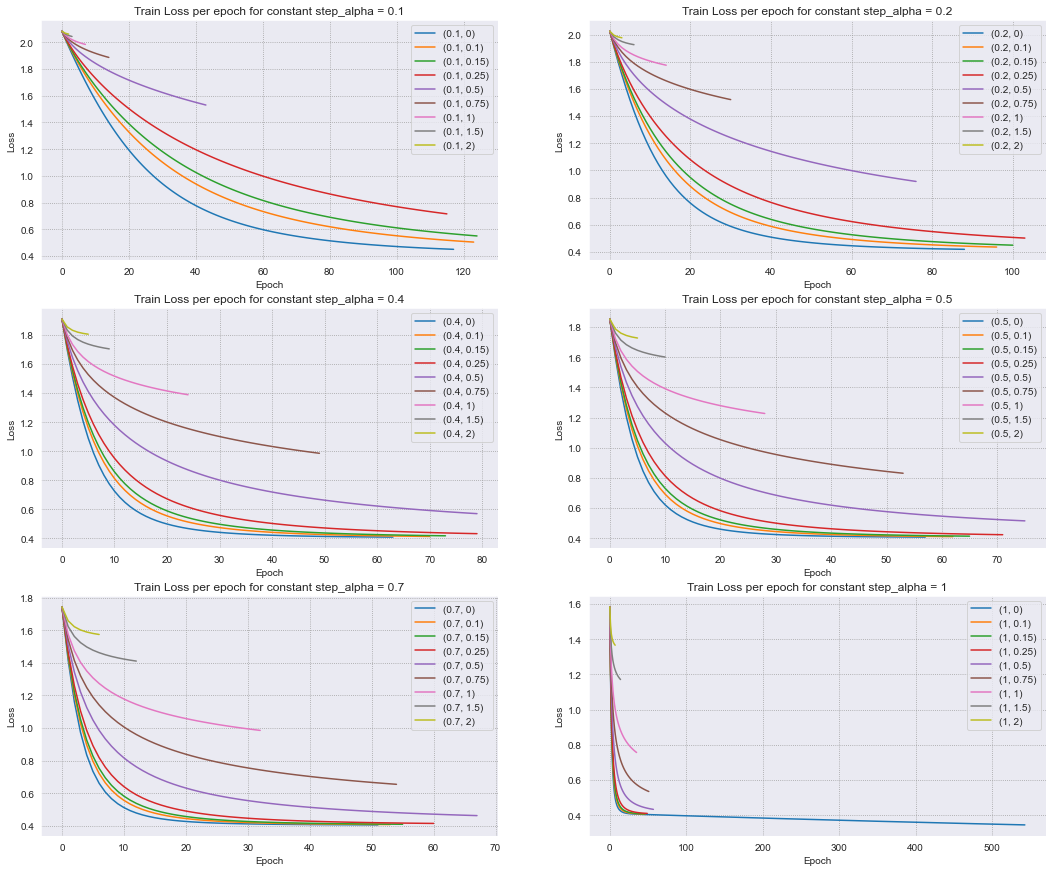

In [23]:
plot_loss_per_epoch(step_alpha_grid, step_beta_grid, res_loss_per_epoch)

##### Валидация

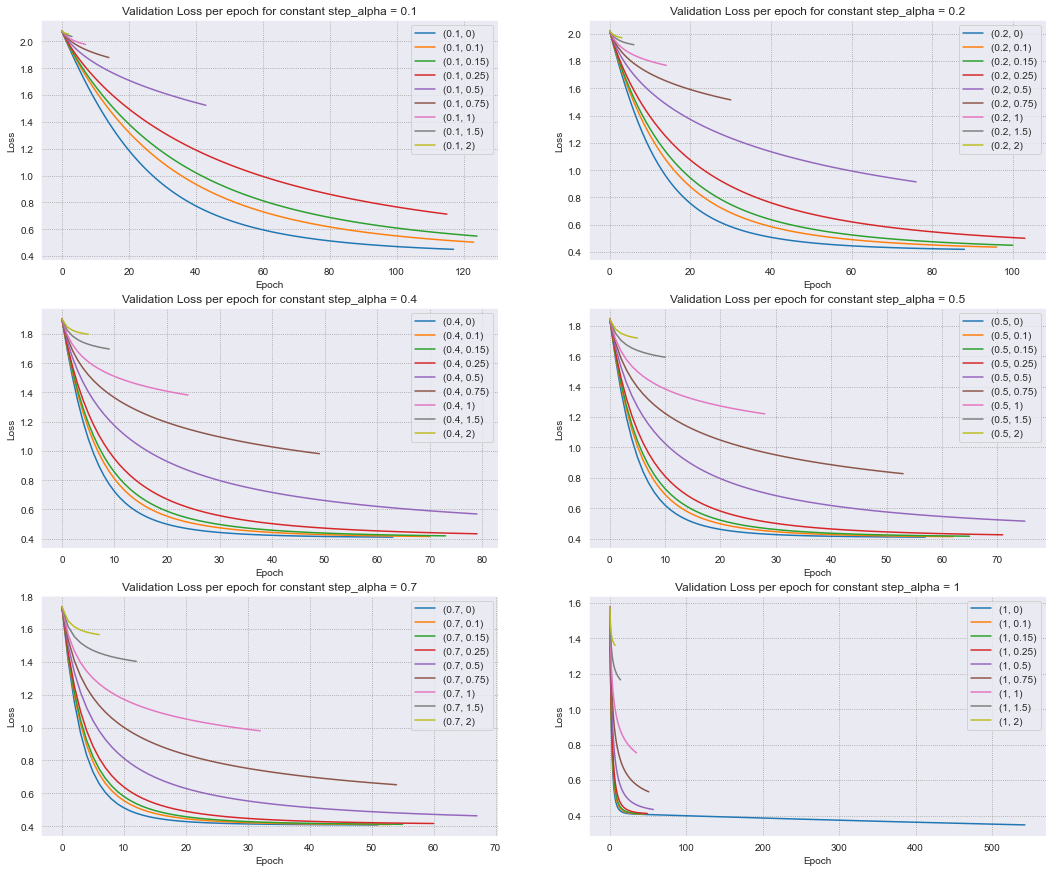

In [24]:
plot_loss_per_epoch(step_alpha_grid, step_beta_grid, res_loss_per_epoch_val, label = 'Validation')

#### Зависимость значения функции потерь от реального времени работы метода

##### Обучение

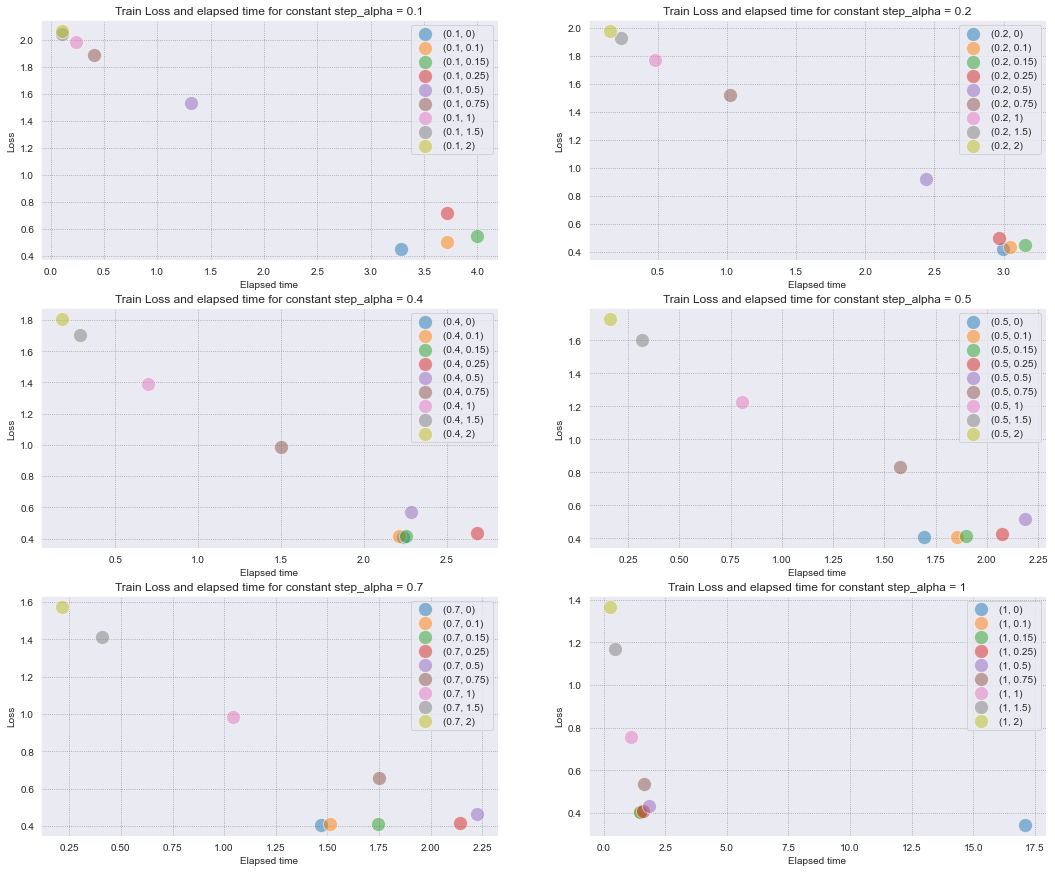

In [25]:
plot_loss_time(step_alpha_grid, step_beta_grid, res_loss, res_time)

##### Валидация

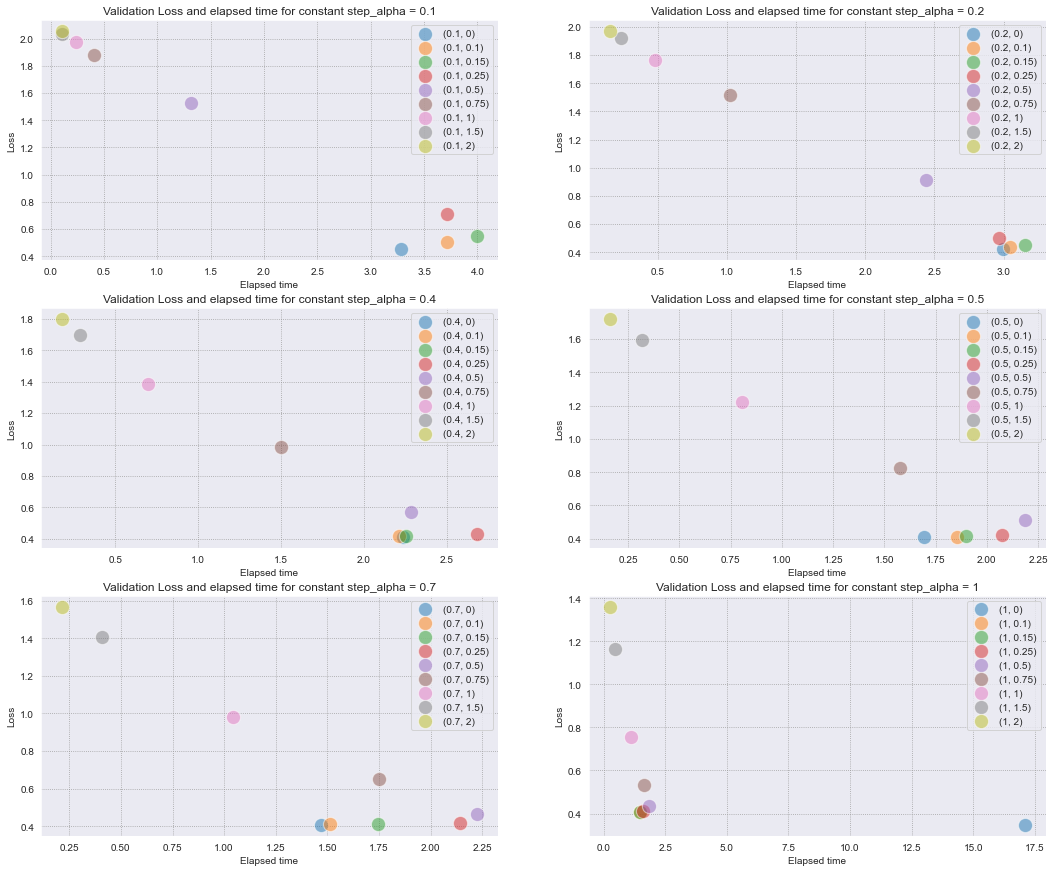

In [26]:
plot_loss_time(step_alpha_grid, step_beta_grid, res_loss_val, res_time, label = 'Validation')

#### Значение метрики качества после обучения метода

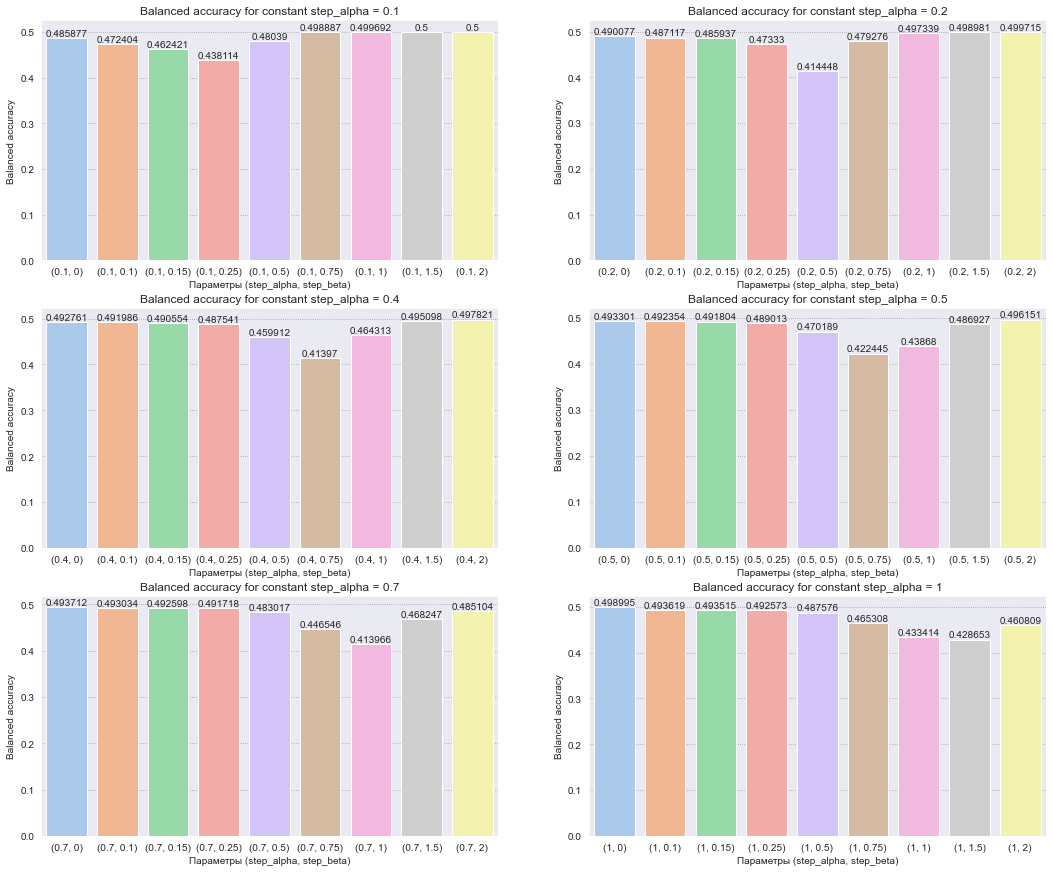

In [27]:
plot_balanced_accuracy(step_alpha_grid, step_beta_grid, res_balanced_acc)

In [28]:
best_accuracy_params = max(res_balanced_acc,  key=res_balanced_acc.get)
print(f'The best balanced accuracy is {res_balanced_acc[best_accuracy_params]} with steps {best_accuracy_params}')

The best balanced accuracy is 0.5 with steps (0.1, 1.5)


#### Ответьте на следующие вопросы

**1. По результатам экспериментов, какие параметры `step_alpha` и `step_beta` вы считаете наиболее оптимальными? Если пар оптимальных параметров получилось несколько, какую пару вы выберете для дальнейших экпериментов и почему?**
 
В целом алгоритмы очень плохо обучились. Возможно, если подобрать порог, результат будет лучше, но сбалансированная точность у всех комбинаций `step_alpha` и `step_beta` примерно одинаковая, поэтому по ней оценивать не будем. 

Я на один порядок понизил параметр tolerance, чтобы алгоритмы быстрее завершали работу. В целом видно, что бОльшая часть комбинаций останавливается в районе 0.4 loss. Лучший loss как на трейне, так и на валидации показал алгоритм с параметрами (1,0), однако когда я искал информацию о том, как правильно подбирать learning rate, я нашёл, что во многих статьях говорится, что learning rate должен быть меньше 1. Так как `step_beta` в этом случае равен нулю, то в этом случае он ещё и константный, то есть не зависит от итерации, что тоже не очень хорошо, можно легко проскочить глобальный минимум.

Поэтому было решено лучшим параметром  в данном эксперименте выбрать пару **(1,0.1)**, мне кажется, это неплохой способ уменьшать lr по ходу итераций, не делая его слишком маленьким, но опять же, очень много параметров показали схожие результаты как по времени обучения, так и по лосу и тут трудно выбрать лучший, скорее это мои предпочтения.

**2. Какие зависимости между параметрами `step_alpha`/`step_beta` и временем работы алгоритма/кол-ва эпох вы наблюдаете? Опишите свои наблюдения.**

Заметно, что при увеличении `step_beta` алгоритмы сходятся очень рано и с все большим лосом, но при этом работают быстро (так как меньше эпох, впрочем это не важно, лосс то плохой). Это можно объяснить тем, что мы начинаем слишком сильно дробить шаг с каждой итерацией и, когда шаг становится слишком маленьким, алгоритм думает, что он попал в минимум и останавливается.

При увеличении `step_alpha` алгоритмы показывают результаты лучше, так как, даже их первый шаг показывает значительно ниже лосс с каждым увеличением. Вообще хорошо первый шаг делать довольно большим, это ускоряет сходимость алгоритма. Чем больше `step_alpha`, тем дольше работают алгоритмы, так как они проскакивают места, где остановились предыдущие варианты с следовательно совершают больше эпох. Самый долгий алгоритм был с константным `step_alpha` = 1, отработал за 17,5 секунд (другие редко работали дольше 4 секунд)
    
**3. Поясните, в чём преимущество использования balanced accuracy для этой задачи по сравнению с обычной accuracy?**

Это связано с балансом классов. Давайте приведем график баланса классов в данной задаче:

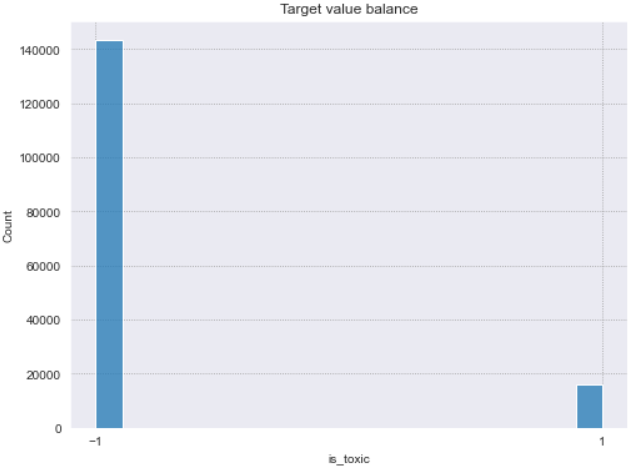

Видно, что классы ужасно сбалансированы и это логично, ведь поймать токсичный комментарий гораздо сложнее, чем хороший (не в русских соц сетях конечно). Представим, что мы используем обычную accuracy и мы алгоритм классификации. Давайте просто всё время называть самый частый класс. Вау! Мы получили 90% процентов accuracy, но на самом деле это конечно не так, мы просто сработали как Dummy classifier с стратегией most frequent. Дело в том, что метрика accuracy нерепрезентативна для задач с плохим балансом классов, поэтому чтобы использовать accuracy, нужно либо урезать датасет до баланса и терять кучу данных, либо пользоваться balanced accuracy, которая не страдает таким недостатком.

### 2. Исследование параметров стахастического градиентного спуска (3 балла)
Исследуйте поведение стохастического градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`
- размер подвыборки `batch_size`

Для данного эксперимента я снизил количество итераций до 250, чтобы подсчет шел быстрее и потому что стохастический градиентный спуск должен быстрее сходиться. Будем перебирать batch_size 4096, 2048, 1024. Пользуемся теми же реализованными выше функциями.

#### Batch_size 4096

In [29]:
batch_size = 4096

step_alpha_grid = [0.1, 0.2, 0.4, 0.5, 0.7, 1]
step_beta_grid = [0, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 1.5, 2]

res_time, res_loss, res_loss_val, res_loss_per_epoch,res_loss_per_epoch_val, res_balanced_acc =\
    get_steps_info(step_alpha_grid, step_beta_grid, batch_size=batch_size, max_iter=250)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [18:13<00:00, 182.25s/it]


##### Зависимость значения функции потерь от эпохи метода

###### Обучение

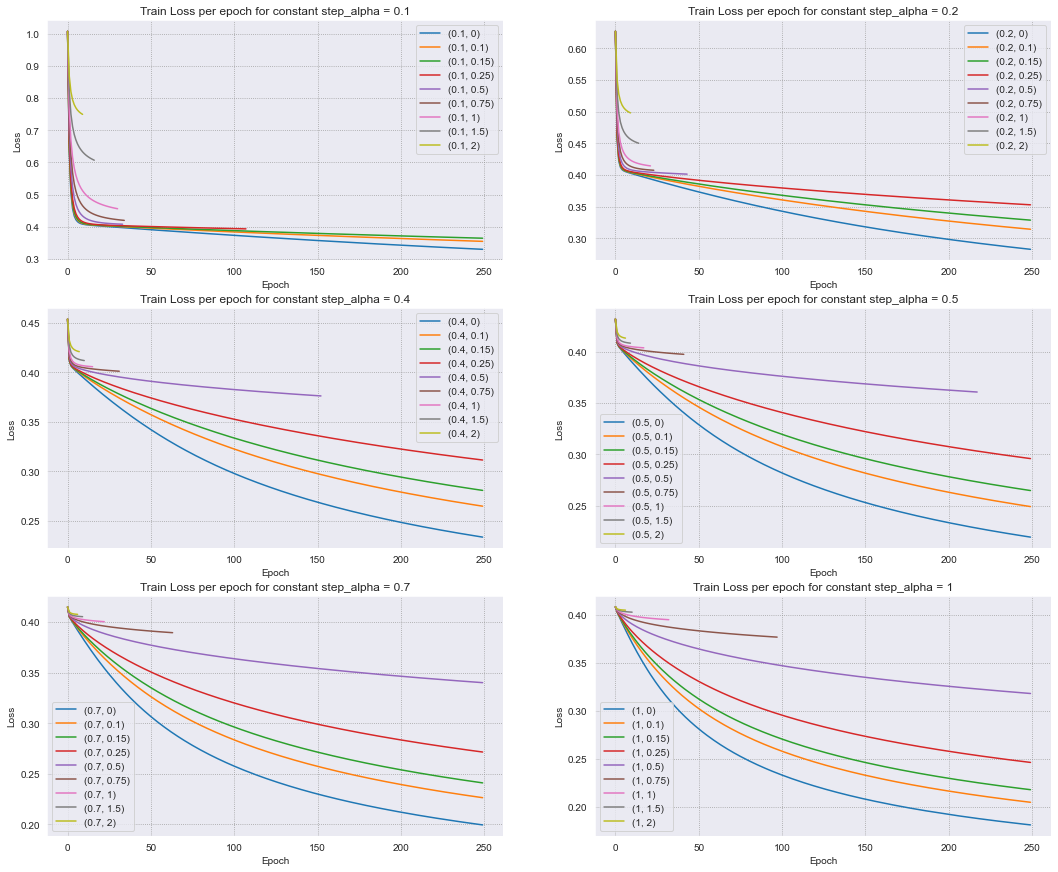

In [30]:
plot_loss_per_epoch(step_alpha_grid, step_beta_grid, res_loss_per_epoch)

###### Валидация

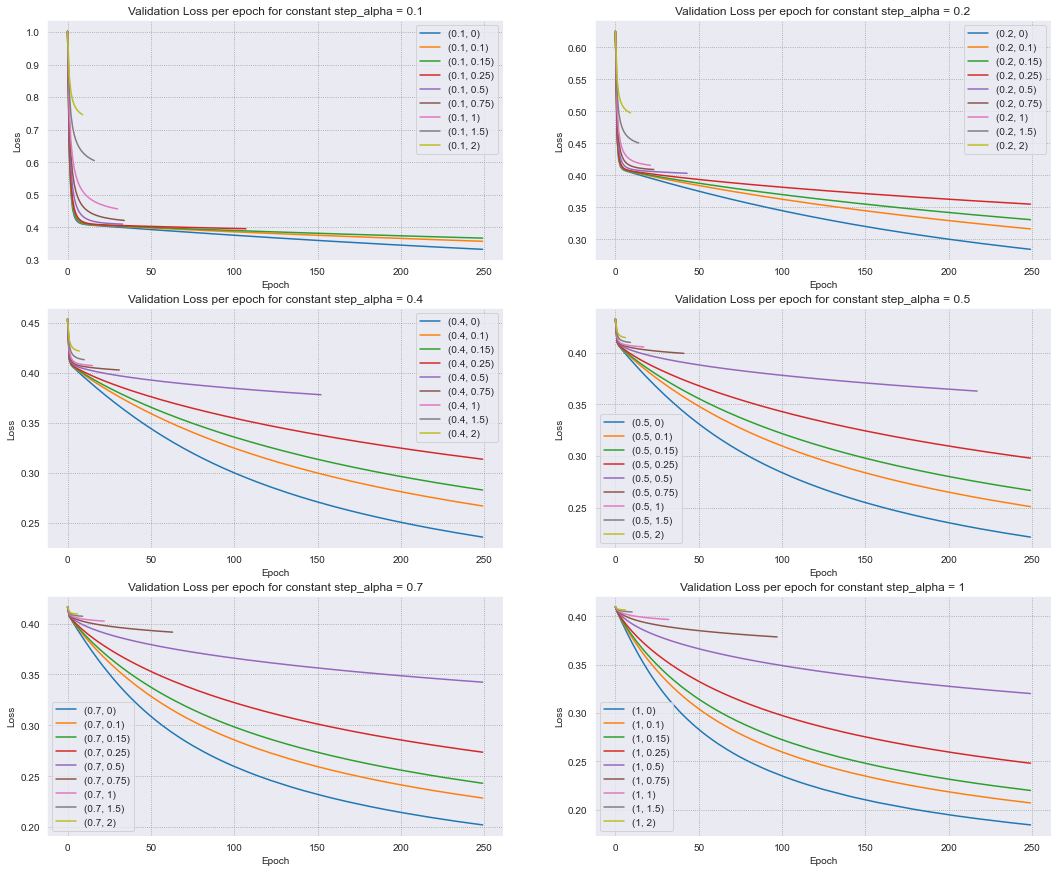

In [31]:
plot_loss_per_epoch(step_alpha_grid, step_beta_grid, res_loss_per_epoch_val, label = 'Validation')

##### Зависимость значения функции потерь от реального времени работы метода

###### Обучение

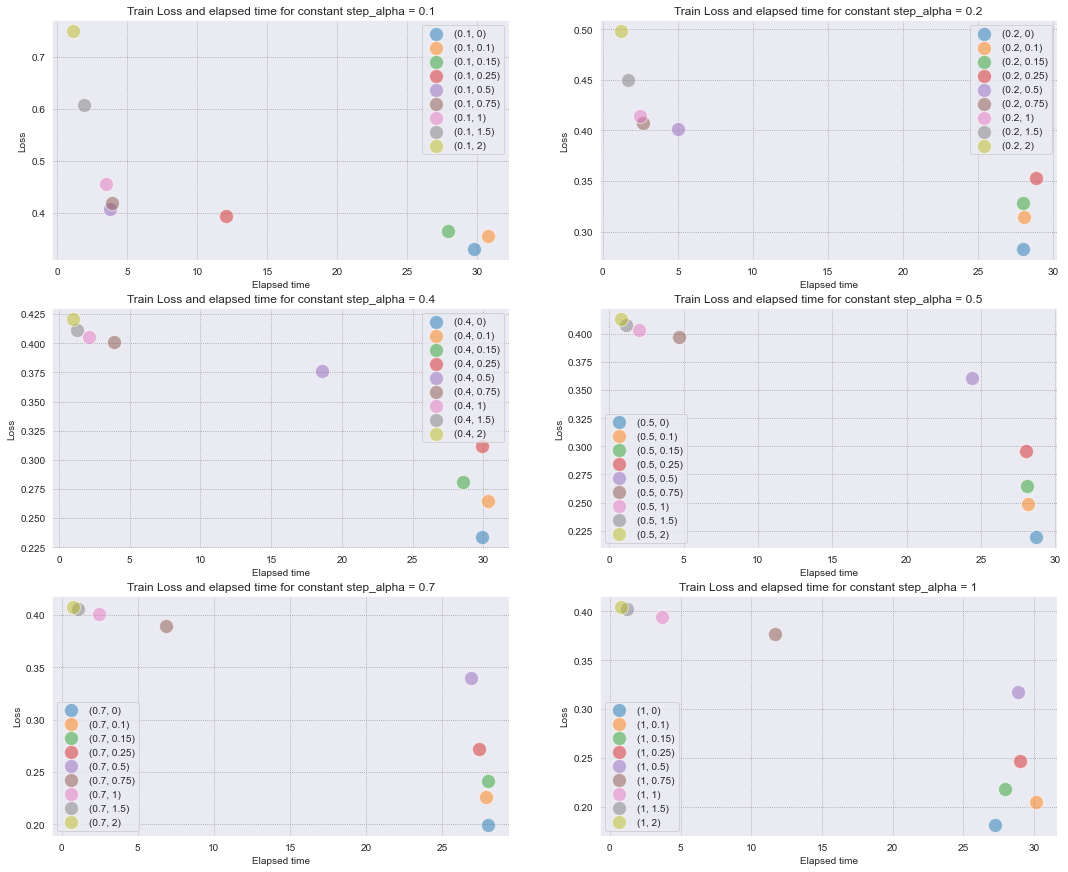

In [32]:
plot_loss_time(step_alpha_grid, step_beta_grid, res_loss, res_time)

###### Валидация

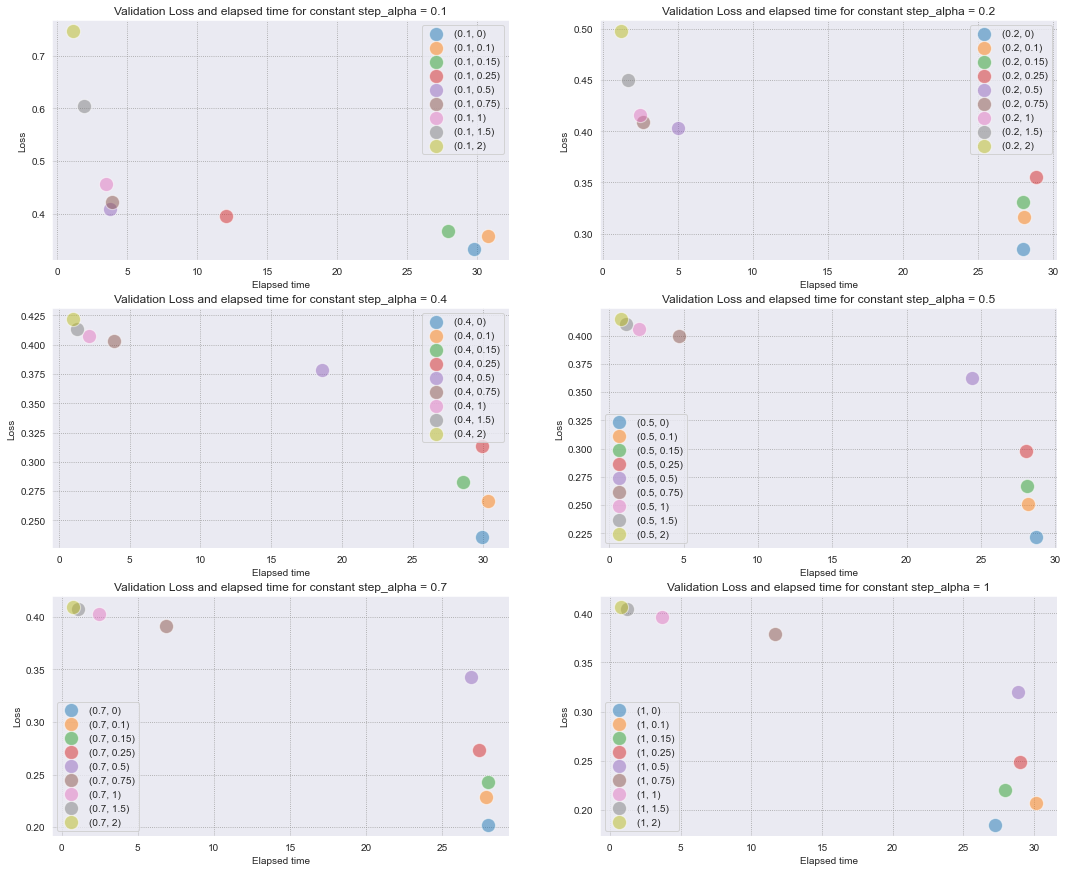

In [33]:
plot_loss_time(step_alpha_grid, step_beta_grid, res_loss_val, res_time, label = 'Validation')

##### Значение метрики качества после обучения метода

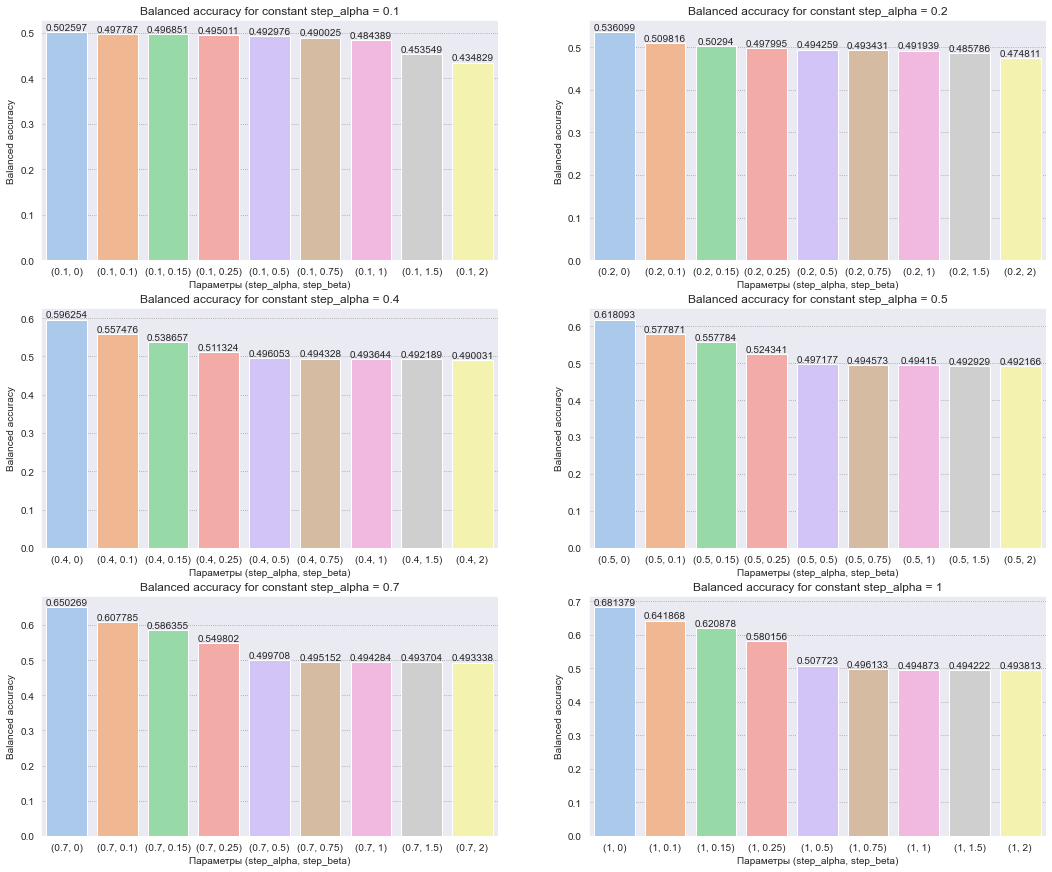

In [34]:
plot_balanced_accuracy(step_alpha_grid, step_beta_grid, res_balanced_acc)

In [35]:
best_accuracy_params = max(res_balanced_acc,  key=res_balanced_acc.get)
print(f'The best balanced accuracy is {res_balanced_acc[best_accuracy_params]} with steps {best_accuracy_params}')

The best balanced accuracy is 0.6813790591951202 with steps (1, 0)


#### Batch_size 2048

In [36]:
batch_size = 2048

step_alpha_grid = [0.1, 0.2, 0.4, 0.5, 0.7, 1]
step_beta_grid = [0, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 1.5, 2]

res_time, res_loss, res_loss_val, res_loss_per_epoch,res_loss_per_epoch_val, res_balanced_acc =\
    get_steps_info(step_alpha_grid, step_beta_grid, batch_size=batch_size, max_iter=250)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [24:23<00:00, 243.99s/it]


##### Зависимость значения функции потерь от эпохи метода

###### Обучение

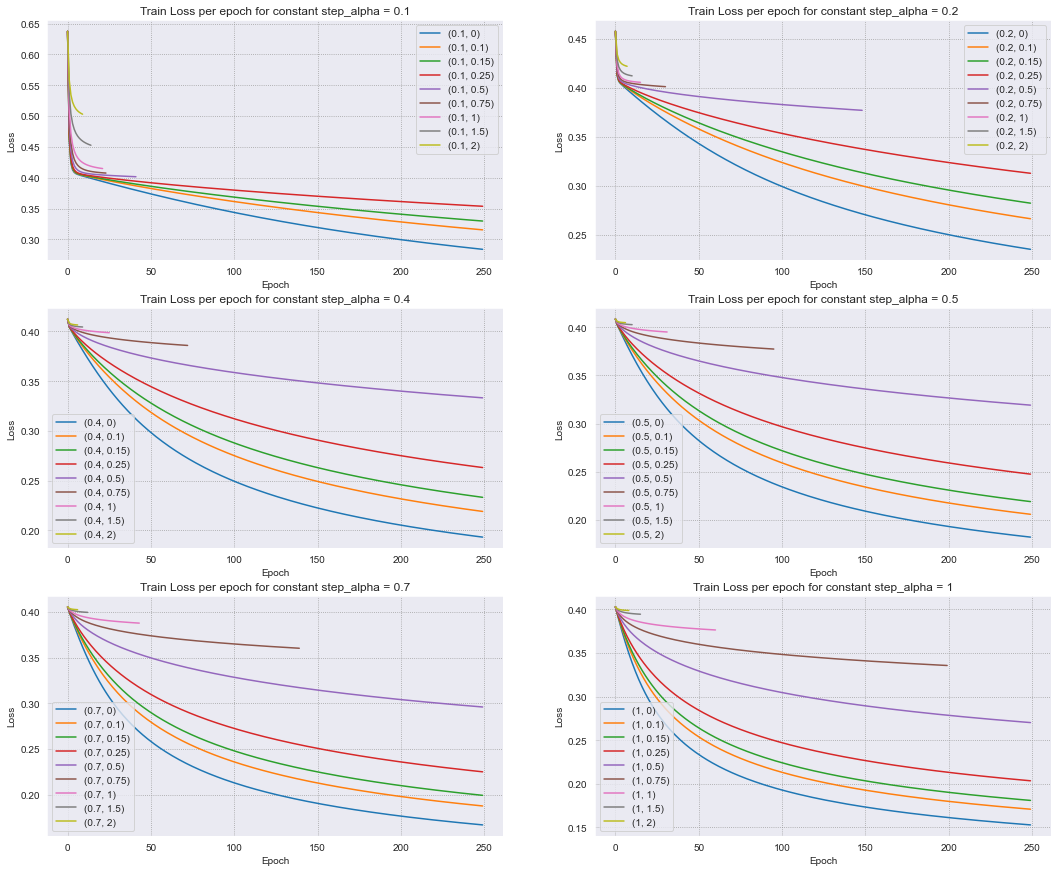

In [37]:
plot_loss_per_epoch(step_alpha_grid, step_beta_grid, res_loss_per_epoch)

###### Валидация

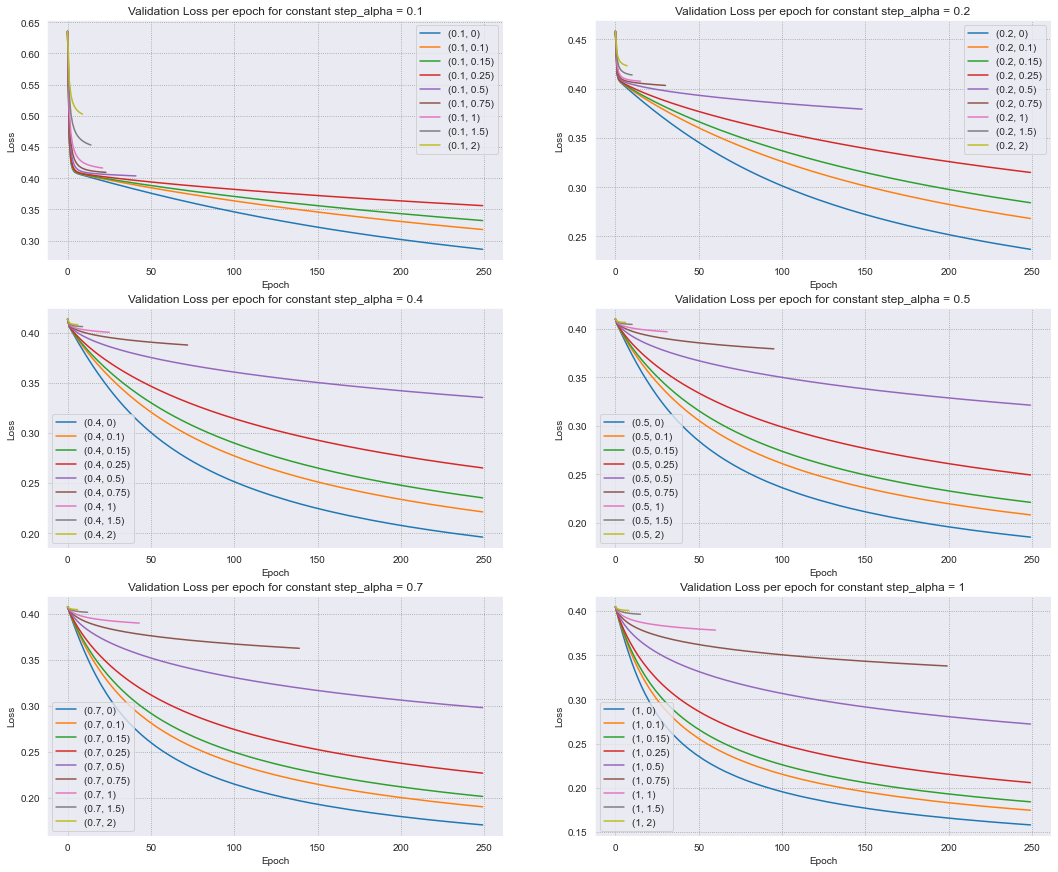

In [38]:
plot_loss_per_epoch(step_alpha_grid, step_beta_grid, res_loss_per_epoch_val, label = 'Validation')

##### Зависимость значения функции потерь от реального времени работы метода

###### Обучение

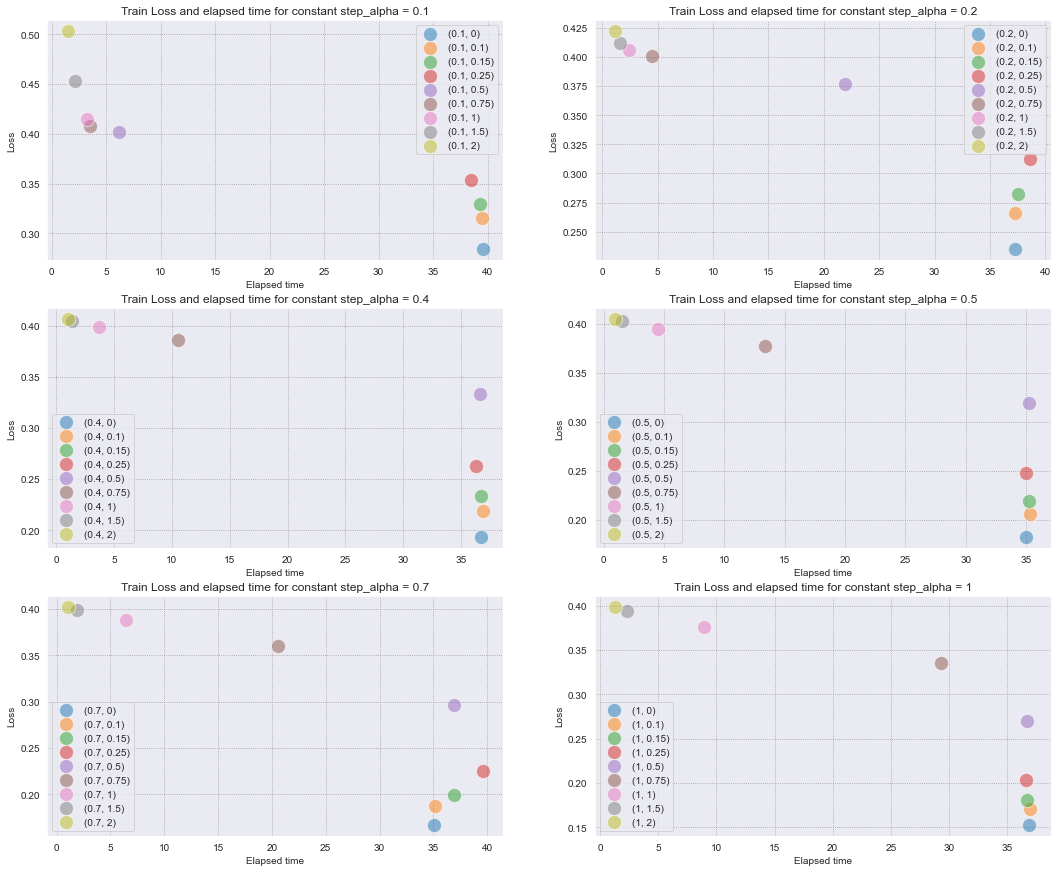

In [39]:
plot_loss_time(step_alpha_grid, step_beta_grid, res_loss, res_time)

###### Валидация

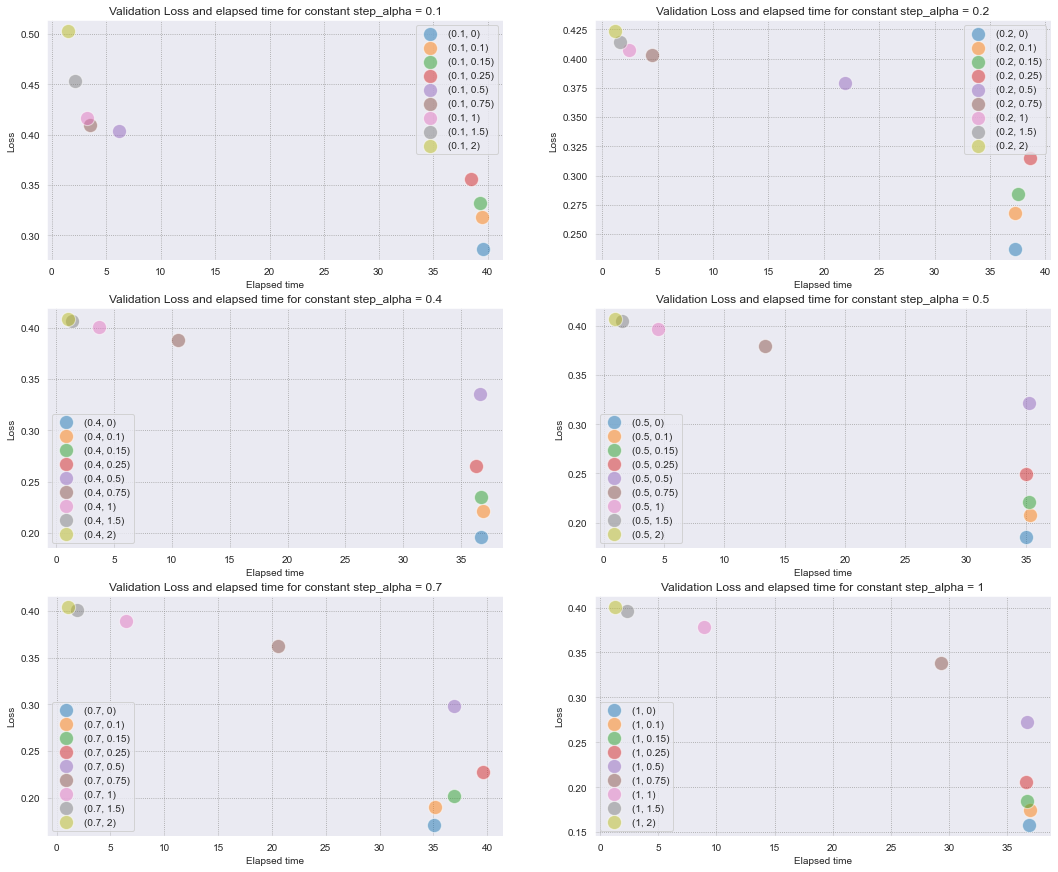

In [40]:
plot_loss_time(step_alpha_grid, step_beta_grid, res_loss_val, res_time, label = 'Validation')

##### Значение метрики качества после обучения метода

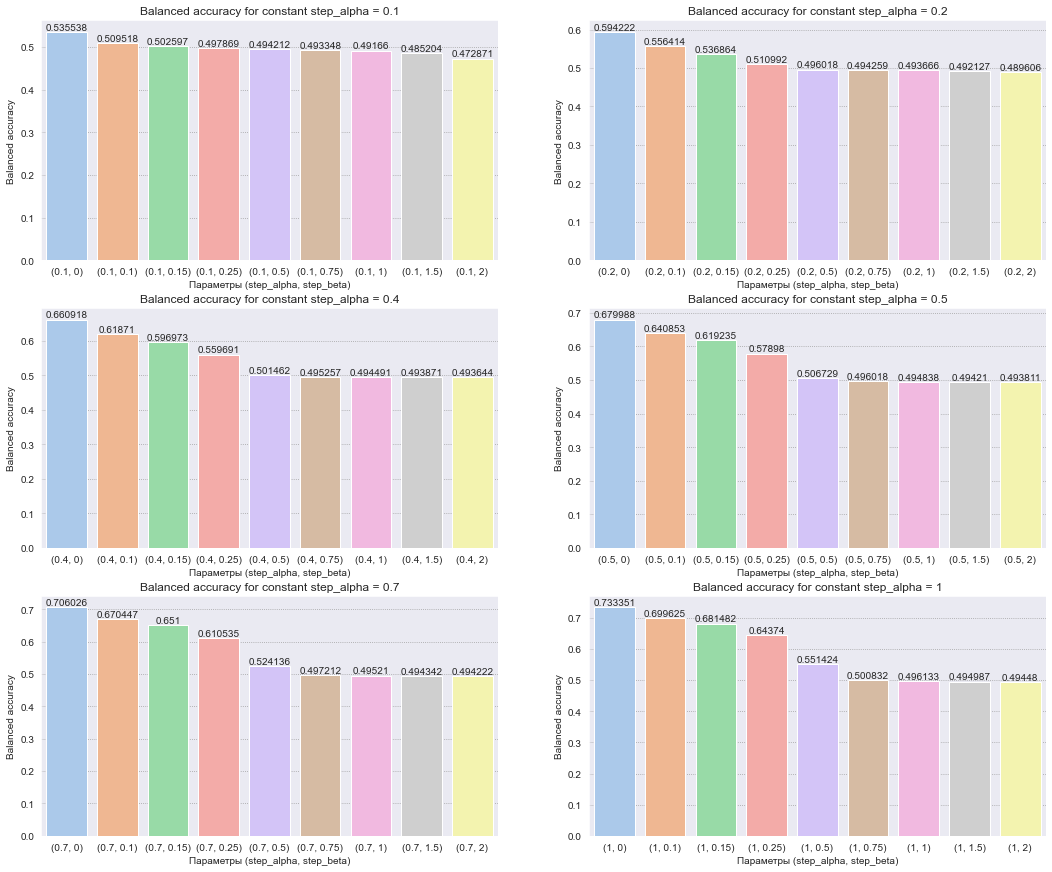

In [41]:
plot_balanced_accuracy(step_alpha_grid, step_beta_grid, res_balanced_acc)

In [42]:
best_accuracy_params = max(res_balanced_acc,  key=res_balanced_acc.get)
print(f'The best balanced accuracy is {res_balanced_acc[best_accuracy_params]} with steps {best_accuracy_params}')

The best balanced accuracy is 0.7333511694121515 with steps (1, 0)


#### Batch_size 1024

In [43]:
batch_size = 1024

step_alpha_grid = [0.1, 0.2, 0.4, 0.5, 0.7, 1]
step_beta_grid = [0, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 1.5, 2]

res_time, res_loss, res_loss_val, res_loss_per_epoch,res_loss_per_epoch_val, res_balanced_acc =\
    get_steps_info(step_alpha_grid, step_beta_grid, batch_size=batch_size, max_iter=250)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [34:35<00:00, 345.89s/it]


##### Зависимость значения функции потерь от эпохи метода

###### Обучение

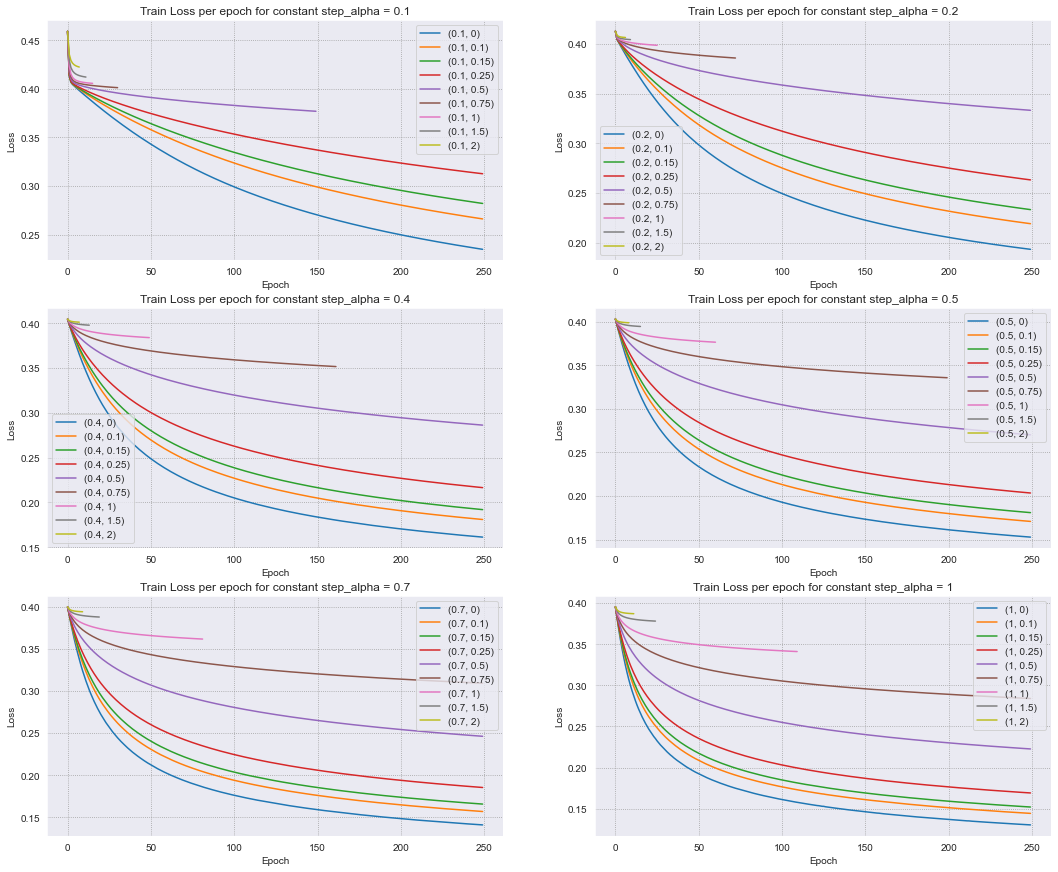

In [ ]:
plot_loss_per_epoch(step_alpha_grid, step_beta_grid, res_loss_per_epoch)

###### Валидация

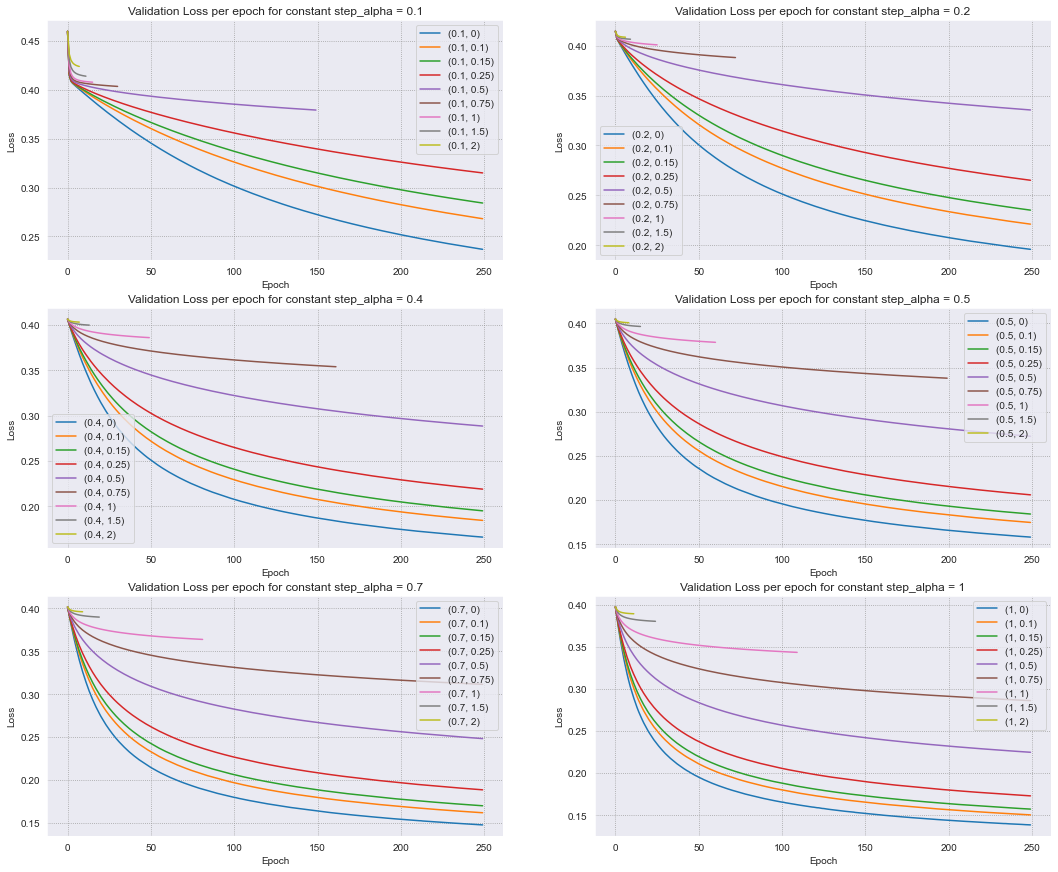

In [ ]:
plot_loss_per_epoch(step_alpha_grid, step_beta_grid, res_loss_per_epoch_val, label = 'Validation')

##### Зависимость значения функции потерь от реального времени работы метода

###### Обучение

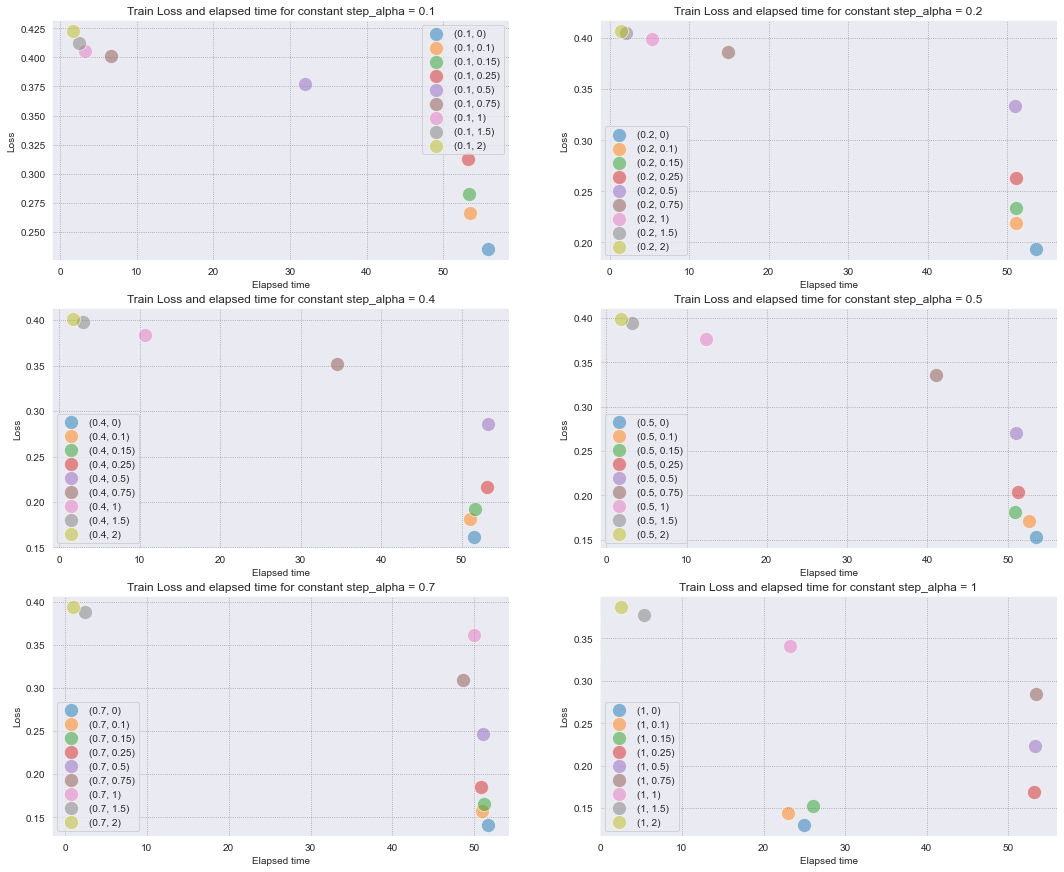

In [ ]:
plot_loss_time(step_alpha_grid, step_beta_grid, res_loss, res_time)

###### Валидация

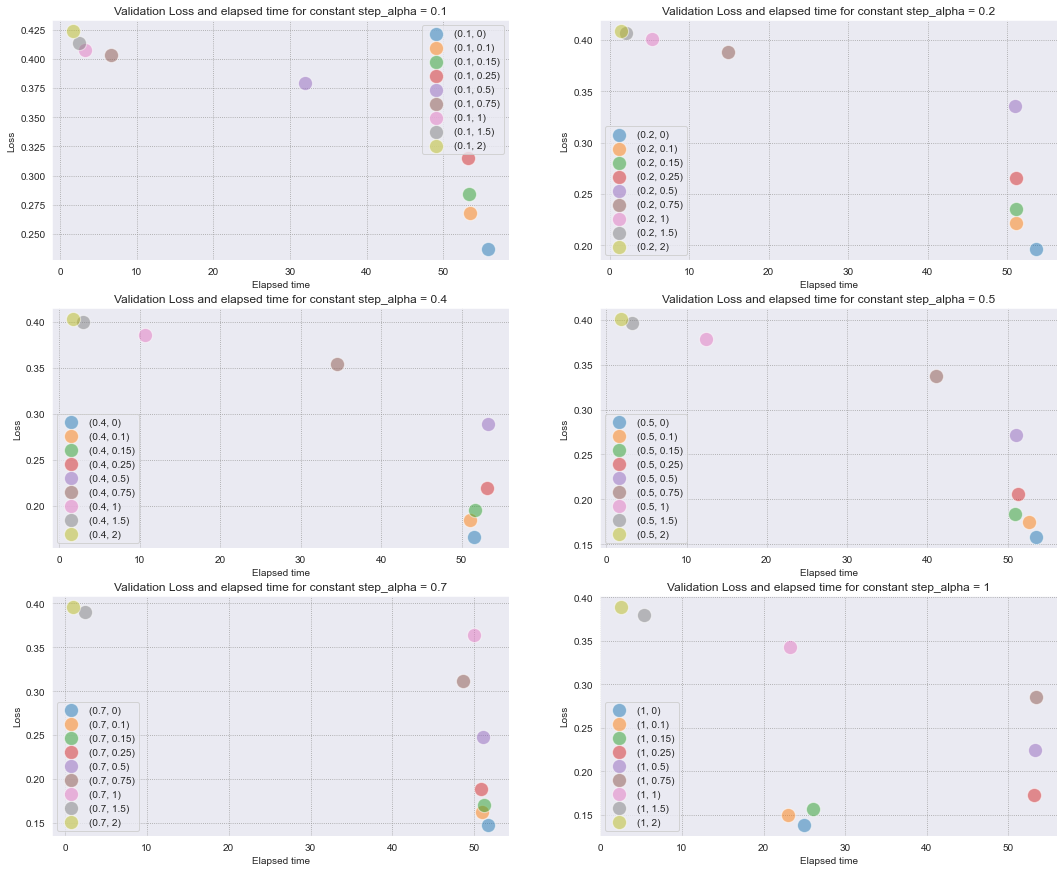

In [ ]:
plot_loss_time(step_alpha_grid, step_beta_grid, res_loss_val, res_time, label = 'Validation')

##### Значение метрики качества после обучения метода

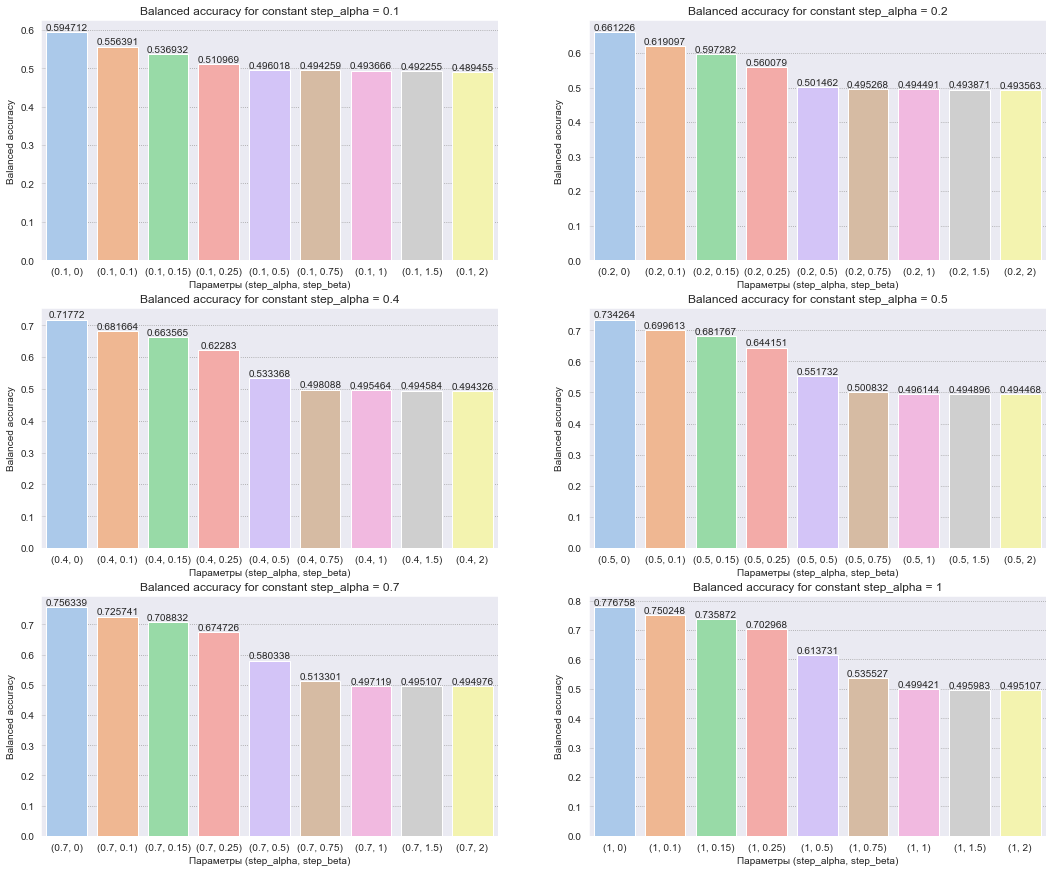

In [48]:
plot_balanced_accuracy(step_alpha_grid, step_beta_grid, res_balanced_acc)

In [49]:
best_accuracy_params = max(res_balanced_acc,  key=res_balanced_acc.get)
print(f'The best balanced accuracy is {res_balanced_acc[best_accuracy_params]} with steps {best_accuracy_params}')

The best balanced accuracy is 0.7767575479974842 with steps (1, 0)


#### Ответьте на следующие вопросы

**1. По результатам экспериментов, какие параметры `step_alpha`, `step_beta` и `batch_size` вы считаете наиболее оптимальными? Если троек оптимальных параметров получилось несколько, какую пару вы выберете для дальнейших экпериментов и почему?**

В этом эксперименте мы уже получаем неплохой скор даже при стандартном пороге. Лучшим по скору стал алгоритм с параметрами (1024, 1, 0), да, работал он конечно долго (25 сек), но это быстрее большей части алгоритмов как с дроблением шага, так и с константным шагов. Но опять же, как и в прошлом эксперименте, я думаю, что нехорошо брать константный шаг, так как можно проскочить глобальный минимум, поэтому лучшим буду считать алгоритм с параметрами (1024, 1, 0.1). Здесь есть все - большой первый шаг, не очень быстрое, но логичное уменьшение этого шага по ходу итераций, хороший скор (0.75) и оптимальное время работы алгоритма, так как бОльшая часть алгоритмов с другими параметрами работала гораздо дольше. Да, он сходится медленнее, чем при (1,0), но можно просто увеличить количество итераций, зато бы с бОльшей вероятностью придем к цели.
    

**2. Какие зависимости между параметрами `step_alpha` алгортим /`step_beta`/`batch_size` и временем работы алгоритма/кол-ва эпох вы наблюдаете? Опишите свои наблюдения.**

Первое, с чего стоит начать, при уменьшении размера батча алгоритм быстрее сходится и даёт лучше скор, поэтому и был выбран минимальный из рассматриваемых размеров батча. С уменьшением размера батча растёт время работы алгоритма, но лучшего выбранного это не касается, он работает наравне с алгоритмами, у которых размер батча больше.

Второе, это видна та же закономерность, что и в первом эксперименте: при сильном дроблении шага (`step_beta`) получаем большой лосс и ухудшается скор, алгоритм сходится дольше, если дробить ОЧЕНЬ сильно, то алгоритм рано завершает работу. К размеру батча это вроде бы не привязано, для всех картина примерно одинаковая.

Ну и при увеличении `step_alpha` алгоритм лучше сходится, не сильно при этом проигрываю по времени предыдущим `step_alpha`.

Для меня интересной картиной стало, что при среднем дроблении шага для всех размеров батча время работы алгоритма больше всего, при этом скор хуже, чем если дробить чуть-чуть или не дробить вовсе. Можно попробовать это объяснить тем, что алгоритм приходит в какой-то минимум, который другой алгоритм с меньшим дроблением проскакивает, и пытается там что-то найти. При этом алгоритм с большим дроблением вовсе не доходит до этого минимума.

Важно, что при стохастическом градиентом спуске получилась хорошая картина по скорам алгоритмов, так из выборки сразу можно отсеивать плохие.


### 3. Сравнение двух методов (2 балла)
Сравните поведение двух методов между собой, и ответьте на следующие вопросы

1. Какой алгоритм вы выберете для дальнейших экспериментов и почему?

 Я выберу стохастический градиентный спуск с параметрами (1024, 1, 0.1).В целом стохастический градиентный спуск быстрее сходится и дает приемлемый срок в отличии от обычного. Увеличив кол-во итераций, настроив порог можно получить еще больший прирост. Конечно, он проигрывает по скорости (кстати выбранные параметры по скорости не сильно проигрывают прошлым лучшим), но лучше чуть-чуть подождать и получить хороший результат, чем получать точность классификации 50%.


2. Есть ли разница между парами оптимальных параметров `step_alpha` и `step_beta` в двух алгоритмах? Объясните разницу/отсутствие разницы в результатах.

По тому, как я выбрал параметры в прошлом эксперименте, разницы нет. В первом эксперименте я мог выбрать и другие параметры, а тут они однозначно лучше. Можно объяснить тем, что мне это и правда самые оптимальные параметры спуска, а в первом задании у меня получилось это интуитивно понять (я выбирал не основываясь на второе задание). Также возможно сетка недостаточно хорошо построена, и если бы параметров было больше, то и результаты бы не совпали. И последнее, это может быть совпадением, исходя из структуры пространства решаемой задачи.

### 4. Регуляризация (2 балла)
**Подберите по отложенной выборке коэффициент $l2$-регуляризации модели.** 

**Приведите график с результатами ваших экспериментов. Обоснуйте свой выбор.**

В этом эксперименте я уже решил настраивать порог для получения хороших результатов, увеличил кол-во итераций до 1000 для лучшего скора и вернул tolerance = 1e-5.

In [17]:
from tqdm import tqdm

l2_grid = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25]

batch_size = 1024
step_alpha = 1
step_beta = 0.1
tolerance = 1e-5
max_iter = 1000

balanced_acc = []
optimal_thresholds = []

for l2 in tqdm(l2_grid):
    loss_function = BinaryLogisticLoss(l2_coef=l2)
    model = LinearModel(
                loss_function=loss_function,
                step_alpha=step_alpha,
                step_beta=step_beta,
                batch_size = batch_size,
                tolerance=tolerance,
                max_iter=max_iter,
                )
    model.fit(X_train, y_train)
    threshold = model.get_optimal_threshold(X_val, y_val)
    y_pred = model.predict(X_val, threshold=threshold)
    score = compute_balanced_accuracy(y_val, y_pred)
    balanced_acc.append(score)
    optimal_thresholds.append(threshold)

balanced_acc

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [09:40<00:00, 72.51s/it]


[0.9046843935023683,
 0.8522161226025715,
 0.8428107564777563,
 0.8150970477837494,
 0.775070435442095,
 0.7362798396694213,
 0.6989984001029657,
 0.6581236218342648]

In [18]:
optimal_thresholds

[-1.9803779308434386,
 -2.191993643196614,
 -2.1931880221988336,
 -2.1940345379481037,
 -2.194320909090502,
 -2.1944158267838727,
 -2.1945056929122355,
 -2.1945308400700587]

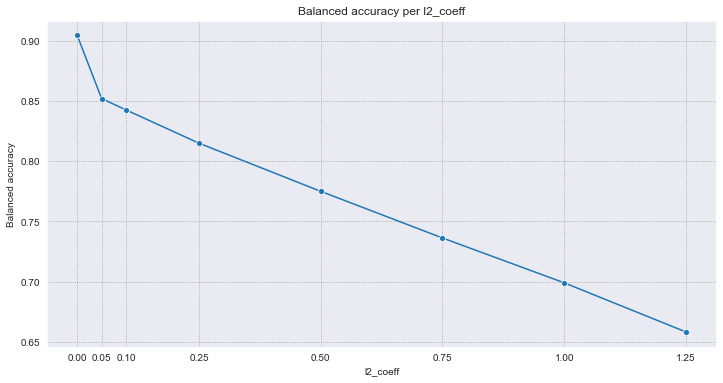

In [19]:
plt.figure(figsize = (12,6))
plt.title('Balanced accuracy per l2_coeff')
sns.lineplot(x = l2_grid, y = balanced_acc, marker = 'o')
plt.xticks(l2_grid)
plt.xlabel('l2_coeff')
plt.ylabel('Balanced accuracy')
plt.show()

На графике видно, что при l2_coeff = 0 мы получили лучший скор на валидации (0.9046843935023683). При добавлении регуляризации и дальнейшем увеличении параметра, скор только падает вниз, даже без скачков. Поэтому логично выбрать для итога l2_coeff = 0.

### 5. Измерение качества и интерпретация результатов (3 балла)
Выберите лучший алгоритм для тестовой выборки. Обратите внимание, что необходимо использовать порог бинаризации, выбранный на отложенной выборке.

По итогу проведенных экспериментов, я буду лучшую модель с параметрами l2_coeff = 0, step_alpha = 1, step_beta = 0.1, batch_size = 1024, num_iter = 1000, tolerance = 1e-5. Оптимальный порог из валидации threshold = -2.211604612658369, но я посчитал его ещё раз (!!! на валидационной выборке), благо это не долго.

Для начала преобразуем тестовую выборку в TF-IDF матрицу:

In [20]:
X_test = np.array(df_test['clear_comment_text'])
y_test = np.array(df_test['is_toxic'])
X_test.shape, y_test.shape

((63978,), (63978,))

In [21]:
X_test = vectorizer.transform(X_test)
X_test = csr_matrix(hstack([csr_matrix(np.ones((X_test.shape[0], 1))), X_test]))
X_test

<63978x26190 sparse matrix of type '<class 'numpy.float64'>'
	with 1615681 stored elements in Compressed Sparse Row format>

In [22]:
model = LinearModel(
                loss_function=BinaryLogisticLoss(l2_coef=0),
                step_alpha=1,
                step_beta=0.1,
                batch_size = 1024,
                tolerance=1e-5,
                max_iter=1000,
                )
model.fit(X_train, y_train)
threshold = model.get_optimal_threshold(X_val, y_val)
y_pred = model.predict(X_test, threshold=threshold)
score = compute_balanced_accuracy(y_test, y_pred)

print(f'Balanced accuracy on Test set: {score}')

Balanced accuracy on Test set: 0.8874530505603012


In [23]:
errors_inds = np.argwhere(y_test != y_pred)
errors_inds

array([[    1],
       [   12],
       [   17],
       ...,
       [63972],
       [63974],
       [63975]], dtype=int64)

In [24]:
pd.options.display.max_colwidth = 200

for ind in errors_inds[:10]:
    text = df_test.iloc[ind]['clear_comment_text'].to_string(length = 300)
    print(f'True label = {y_test[ind]}, Predicted label = {y_pred[ind]}')
    print('-----------------Text--------------------')
    print(text[:1000])
    print('-----------------------------------------')

True label = [-1], Predicted label = [1.]
-----------------Text--------------------
1    dear god site horrible
-----------------------------------------
True label = [-1], Predicted label = [1.]
-----------------Text--------------------
12    jew race get mother mention ethiopian jew testing jew prof well fact accept convert
-----------------------------------------
True label = [-1], Predicted label = [1.]
-----------------Text--------------------
17    balance page ha one sentence basic definition word huge amount slang profane us perhaps former extended information female dog available beyond name encyclopaedia dictionary feel whoever looking d...
-----------------------------------------
True label = [-1], Predicted label = [1.]
-----------------Text--------------------
27    burn hell revoke talk page access
-----------------------------------------
True label = [-1], Predicted label = [1.]
-----------------Text--------------------
50    avg plenty greek love king stop acting lik

#### Ответьте на следующие вопросы

1. Примените лучший алгоритм к тестовой выборке и посмотрите на метрику качества. Сравните ее с метрикой на валидации. Опишите ваши наблюдения.

На тесте получен скор 0.8874530505603012, на валидации был 0.9. Значения довольно близкие, что говорит об отсутствии переобучения модели. В принципе результат неплохой. Его можно улучшить, добавляя нграммыы, снижая параметр mindf у TF-IDF преобразования, но так придётся заново подбирать оптимальные параметры, данных станет больше и вся работа будет гораздо дольше.

2. Проанализируйте ошибки алгоритма. Проанализируйте и укажите общие черты объектов, на которых были допущены ошибки. Наблюдения опишите.

В первой ошибке алгоритм предсказал, что комментарий токсичный, хотя это не так. Этому есть объяснение, так как в тексте встречается слово horrible, что в переводе ужасный. Это слово часто встречается в плохих комментариях, поэтому алгоритм предсказал такую метку.

Во второй строке я ничего не заметил, зато в 3 есть слово profane, что означает нецензурную брань, ну хоть что-то, хотя дальше есть ещё текст. Предсказанная метка токсик, на самом деле нет.

В четвертой строке есть hell, что означает ад, нграммы не учитывались, но словосочетание burn hell как бы намекает на токсичность комментария, хотя его метка обратная.

Ну и так далее, видно, что алгоритм часто ошибается, считая нетоксичный комментарий токсичным и это связано с ключевыми словами, которые более характерны для токсичных комментариев, wtf(перевод понятен), kill (это конечно про черную мамбу, но звучит плохо), troll(тролить), снова horrible и так далее.

3. Проинтерпретируйте линейные коэффициенты признаков. Выберите коэффициенты с набиольшим значением и коэффициенты с наименьшим значением. Проанализируйте, каким словам они соответствуют. Согласуются ли ваши наблюдения с вашими ожиданиями от модели?

Отсортируем веса и выделим индексы top10 - 10 самых плохих по мнению модели слов, bot10 - 10 самых хороших слов. Также преобразуем словарь tf-idf  из слово-индекс, в индекс - слово, чтобы было удобнее проводить поиск. 

In [95]:
weights = model.weights
ind = np.argsort(weights)
bot10 = ind[:10]
top10 = ind[-1:-11:-1]

voc = vectorizer.vocabulary_
voc = {value : key for key, value in voc.items()}

In [96]:
print('BAD words')
print('------------------------------------------------')
for ind in top10:
    print(f'For word \'{voc[ind]}\' the weight value is {weights[ind]}')
    
print('\nGOOD words')
print('------------------------------------------------')
for ind in bot10:
    print(f'For word \'{voc[ind]}\' the weight value is {weights[ind]}')

BAD words
------------------------------------------------
For word 'fucka' the weight value is 20.513989402647468
For word 'fucktard' the weight value is 16.816141986987482
For word 'shitbag' the weight value is 14.863041160710356
For word 'idiotic' the weight value is 14.730522064557277
For word 'stupidest' the weight value is 13.682316679093294
For word 'sucked' the weight value is 12.718870981457256
For word 'assign' the weight value is 11.593895135846036
For word 'bitchass' the weight value is 10.646160028731623
For word 'dickens' the weight value is 10.288565597568274
For word 'bully' the weight value is 10.20958943861823

GOOD words
------------------------------------------------
For word 'thanksgiving' the weight value is -5.087414244360935
For word 'thanked' the weight value is -4.028683783813582
For word 'maya' the weight value is -3.6841327160805233
For word 'sectional' the weight value is -3.6367593522659023
For word 'pleased' the weight value is -3.5328075865877437
For wo

Посмотрим на самые плохие по мнению модели слова. В основном это нецензурные либо оскорбительные слова (переводить не буду, вроде и так все понятно). В целом это правильное поведения модели по детекции токсичных комментариев, кроме затесавшегося с большим весом слова assign (вроде переводится назначать), откуда оно тут, не совсем понятно.

Если взглянуть на хорошие слова, в топ 5 видно явные положительные слова в виде благодарностей, но встречаются и слова, вклад которых в положительность комментария непонятен, например sectional и совсем непонятное слово maya. Далее уже идут слова типо wouldnt, stated, articled, redirected, которые, по моему мнению, вносят сомнительный вклад в положительность комментария. Откуда то взялось 00, похоже косячок предобработки..

Видно, что хорошо научилась определять токсичные комментарии, а с положительными комментариями дела чуть хуже. Это объясняет то, что модель часто считает положительный комментарий плохим из-за некоторых ключевых слов.

Давайте так посмотрим на 10 слов, веса которых близки к нулю, то есть почти не имеют вклада в ответ алгоритма.

In [97]:
weights = abs(model.weights)
ind = np.argsort(weights)
bot10 = ind[:10]

print('Words with minimal weights')
print('------------------------------------------------')
for ind in bot10:
    print(f'For word \'{voc[ind]}\' the weight value is {weights[ind]}')

Words with minimal weights
------------------------------------------------
For word 'elephant' the weight value is 1.428638305122528e-05
For word 'josephus' the weight value is 3.563598368449001e-05
For word 'nicest' the weight value is 5.615271804554222e-05
For word 'staunch' the weight value is 7.098127510522598e-05
For word 'hi' the weight value is 9.103001874987916e-05
For word 'columbia' the weight value is 0.00012228320055529746
For word 'off2riorob' the weight value is 0.00012587051629306715
For word 'strangely' the weight value is 0.0001445192069496643
For word 'london' the weight value is 0.00015597487796541757
For word 'seo' the weight value is 0.00025606466819223


Тут в целом картина понятная, нет слов, которые явно говорили бы о токсичности комментария или об обратном (разве что слово nicest кажется положительным). В целом модель неплохо определяет ключевые для решения задачи слова.